# **Politecnico di Milano**
## *Student: Caravano Andrea*

*A.Y.: 2023/2024*

*Last modified: 09/09/2024*

### Description: Wireless Internet/Wireless Networks project: Wi-Fi encrypted traffic classification

In [3]:
# Install tshark and pyshark to elaborate packets in pcaps
!apt-get install tshark
!pip install pyshark

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tshark is already the newest version (3.6.2-2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [4]:
import pyshark
import os
import nest_asyncio
import pandas as pd
import numpy as np

target_addr = '8a:c4:06:ee:1d:83' # target address on which we are applying the ML algorithm

dataset = [] # final datasets
traffic_types = ['youtube', 'speedtest', 'web', 'idle']

for tt in range(0, len(traffic_types)):
  print('Processing {} packets...'.format(traffic_types[tt]))
  # We load the file (uploaded via drag and drop)
  nest_asyncio.apply()
  cap = pyshark.FileCapture('{}-filtered.pcapng'.format(traffic_types[tt]))

  # buffers
  TIMESTAMP = [] # array (in ms)
  DIRECTION = [] # up (sa = target)/down (da = target)
  LENGTH = [] # in bytes

  failed = 0 # count packets not correctly parsed
  count = 0 # count total packats

  # Note: captures have already been filtered via Wireshark (export only filtered ones, so as to match source and destination address)

  # Processing of packets
  for frame in cap:
    count += 1 # overall count
    success = False # malformed packets

    try:
      layers = frame.layers # pointer to layers
      timestamp = frame.sniff_timestamp # TS in ms
      sa = layers[2].sa # 802.11 frame: Source address
      da = layers[2].da # 802.11 frame: Destination address
      length = int(frame.length) # frame length
      success = True # packet is non malformed
    except:
      failed += 1 # processing failed: counting the packet as malformed
      success = False

    # add read parameters to buffers
    if (success):
      TIMESTAMP.append(timestamp)
      # compute direction
      if (sa == target_addr):
        direction = "up"
      else: # (da == target_addr), read note!
        direction = "down"
      DIRECTION.append(direction)
      LENGTH.append(length)

  print("{} frames could not be processed on {} total".format(failed, count))

  # parse timestamps as integers (the window parameter is in seconds)
  INT_TIMESTAMP = []
  for t in TIMESTAMP:
    INT_TIMESTAMP.append(round(float(t)))

  W = 1 # window parameter, integer parameter in seconds that tells frequency on which aggregated data is computed

  UP_COUNT = [0] # count packets up
  DOWN_COUNT = [0] # count packets down

  j = 0 # rounds counter (number of rounds = total packets / different timestamps)
  ts_buffer = INT_TIMESTAMP[0] # latest timestamp being tracked

  # average packet length
  AVG_LENGTH_UP = [0]
  AVG_LENGTH_DOWN = [0]

  # length buffer
  LENGTH_UP_BUFFER = []
  LENGTH_DOWN_BUFFER = []

  # variance of packet length
  VAR_LENGTH_UP = [0]
  VAR_LENGTH_DOWN = [0]

  # inter-arrival packet times
  TS_ROUND_UP_BUFFER = []
  TS_ROUND_DOWN_BUFFER = []
  AVG_INTER_UP = [0]
  AVG_INTER_DOWN = [0]
  VAR_INTER_UP = [0]
  VAR_INTER_DOWN = [0]
  ts_counter = 0

  # processing
  for i in range(0, len(INT_TIMESTAMP)):
    if (INT_TIMESTAMP[i] >= ts_buffer + W): # grouping by timestamp (round)
      # variance computation of the latest round
      VAR_LENGTH_UP[j] = np.var(LENGTH_UP_BUFFER)
      VAR_LENGTH_DOWN[j] = np.var(LENGTH_DOWN_BUFFER)
      VAR_INTER_UP[j] = np.var(TS_ROUND_UP_BUFFER)
      VAR_INTER_DOWN[j] = np.var(TS_ROUND_DOWN_BUFFER)

      # new round: initialization...
      UP_COUNT.append(0)
      DOWN_COUNT.append(0)
      AVG_LENGTH_UP.append(0)
      AVG_LENGTH_DOWN.append(0)
      VAR_LENGTH_UP.append(0)
      VAR_LENGTH_DOWN.append(0)
      AVG_INTER_UP.append(0)
      AVG_INTER_DOWN.append(0)
      VAR_INTER_UP.append(0)
      VAR_INTER_DOWN.append(0)
      LENGTH_UP_BUFFER = []
      LENGTH_DOWN_BUFFER = []
      TS_ROUND_UP_BUFFER = []
      TS_ROUND_DOWN_BUFFER = []
      # preparing new round...
      ts_buffer = INT_TIMESTAMP[i]
      j += 1
    # computations
    if (DIRECTION[i] == 'up'):
      UP_COUNT[j] += 1
      AVG_LENGTH_UP[j] += LENGTH[i]
      LENGTH_UP_BUFFER.append(LENGTH[i])
      TS_ROUND_UP_BUFFER.append(float(TIMESTAMP[i]) - float(TIMESTAMP[i - 1]))
      if (i > 0):
        AVG_INTER_UP[j] += float(TIMESTAMP[i]) - float(TIMESTAMP[i - 1])
    else:
      DOWN_COUNT[j] += 1
      AVG_LENGTH_DOWN[j] += LENGTH[i]
      LENGTH_DOWN_BUFFER.append(LENGTH[i])
      TS_ROUND_DOWN_BUFFER.append(float(TIMESTAMP[i]) - float(TIMESTAMP[i - 1]))
      if (i > 0):
        AVG_INTER_DOWN[j] += float(TIMESTAMP[i]) - float(TIMESTAMP[i - 1])

  # variance computation of the last round
  VAR_LENGTH_UP[j] = np.var(LENGTH_UP_BUFFER)
  VAR_LENGTH_DOWN[j] = np.var(LENGTH_DOWN_BUFFER)
  VAR_INTER_UP[j] = np.var(TS_ROUND_UP_BUFFER)
  VAR_INTER_DOWN[j] = np.var(TS_ROUND_DOWN_BUFFER)

  # average computation
  for j in range(0, len(UP_COUNT)):
    if (AVG_LENGTH_UP[j] != 0):
      AVG_LENGTH_UP[j] /= UP_COUNT[j]
      AVG_INTER_UP[j] /= UP_COUNT[j]
    if (AVG_LENGTH_DOWN[j] != 0):
      AVG_LENGTH_DOWN[j] /= DOWN_COUNT[j]
      AVG_INTER_DOWN[j] /= DOWN_COUNT[j]

  # transform regular array into numpy arrays, it is necessary for panda computation
  UP_COUNT = np.array(UP_COUNT)
  DOWN_COUNT = np.array(DOWN_COUNT)
  AVG_LENGTH_UP = np.array(AVG_LENGTH_UP)
  AVG_LENGTH_DOWN = np.array(AVG_LENGTH_DOWN)
  VAR_LENGTH_UP = np.array(VAR_LENGTH_UP)
  VAR_LENGTH_DOWN = np.array(VAR_LENGTH_DOWN)
  AVG_INTER_UP = np.array(AVG_INTER_UP)
  AVG_INTER_DOWN = np.array(AVG_INTER_DOWN)
  VAR_LENGTH_UP = np.array(VAR_LENGTH_UP)
  VAR_LENGTH_DOWN = np.array(VAR_LENGTH_DOWN)

  # final dataset, classified by type
  # it will then be joined
  dataset.append(pd.DataFrame({'frames_up': UP_COUNT[:], 'frames_down': DOWN_COUNT[:], 'avg_length_up': AVG_LENGTH_UP[:], 'avg_length_down': AVG_LENGTH_DOWN[:], 'var_length_up': VAR_LENGTH_UP[:], 'var_length_down': VAR_LENGTH_DOWN[:], 'avg_inter_up': AVG_INTER_UP[:], 'avg_inter_down': AVG_INTER_DOWN[:], 'var_inter_up': VAR_INTER_UP[:], 'var_inter_down': VAR_INTER_DOWN[:],'type': '{}'.format(traffic_types[tt])}).dropna())

Processing youtube packets...
0 frames could not be processed on 12425 total
Processing speedtest packets...


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


12 frames could not be processed on 20111 total
Processing web packets...
5 frames could not be processed on 12810 total
Processing idle packets...
0 frames could not be processed on 7611 total


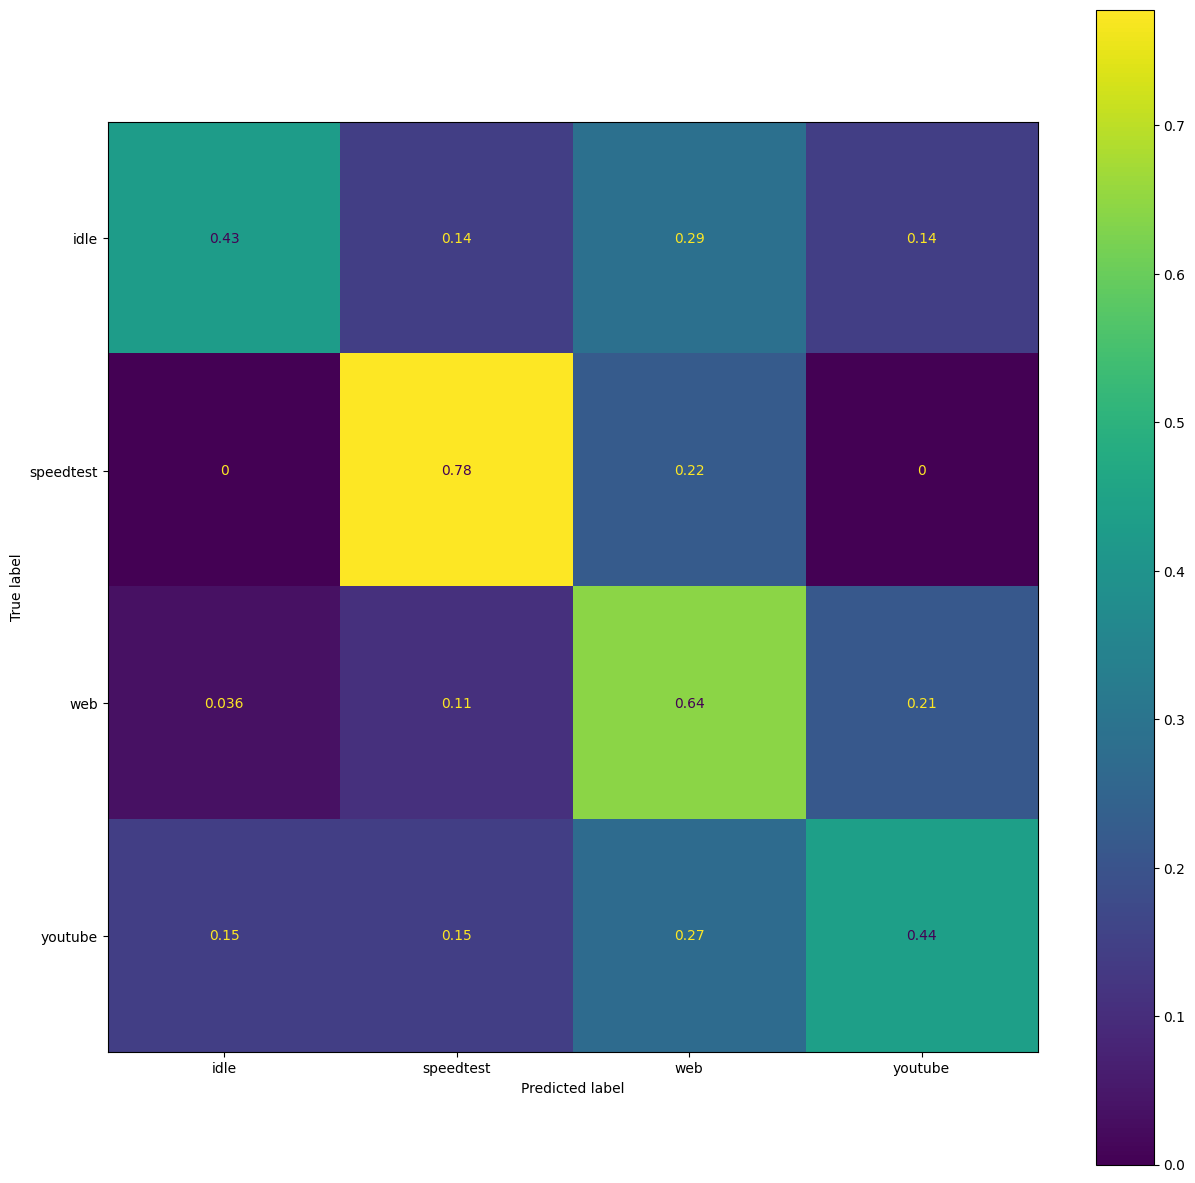

In [99]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# join all datasets
joined_ds = pd.concat([dataset[0], dataset[1], dataset[2], dataset[3]])

scaler = StandardScaler();

X = joined_ds;
Y = X['type'];
X = X.drop('type',axis=1);

X_norm = scaler.fit_transform(X);

X_train, X_test, y_train, y_test = train_test_split(X_norm, Y, test_size=0.5) # 50% will be used for the training set, the rest for the testing set

# K-NeirestNeighbor (up to 4)
# as seen for localization fingerprinting
ACCURACY = []
for k in range(1,5):
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn.fit(X_train, y_train)
  knn_predict = knn.predict(X_test)
  accuracy = accuracy_score(y_test, knn_predict)
  ACCURACY.append(accuracy)
  # print(accuracy)

# we finally plot the confusion matrix
bestk = np.argmax(ACCURACY)+1
knn = KNeighborsClassifier(n_neighbors=bestk, weights='distance')
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
fig, ax = plt.subplots(figsize=(15, 15));
ConfusionMatrixDisplay.from_predictions(knn_predict, y_test, ax=ax, normalize='true');